<a href="https://colab.research.google.com/github/jsegovia1984/GerryVideos/blob/master/MPF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas openpyxl XlsxWriter

import os,re
import pandas as pd
from google.colab import drive

drive.mount('/content/drive/')
!ls "/content/drive/My Drive/MPF" #origen de los datos unificados (3 semestres)

def load_file(filename):
    filename = '/content/drive/My Drive/MPF/' + filename
    df = pd.read_excel(filename, engine='openpyxl').sort_values(by='Orden', ascending=True)
    print(df.columns)
    df['Jurisdicción'] = df['Jurisdicción'].replace('Capital Federal', 'CABA')
    df['Provincia'] = df['Provincia'].replace('Neuquen', 'Neuquén')
    df['Provincia'] = df['Provincia'].replace('Rio Negro', 'Río Negro')
    df['Provincia'] = df['Provincia'].replace('Ciudad Autonoma de Buenos Aires', 'CABA')

    return df


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 2.5 MB/s eta 0:00:00
Mounted at /content/drive/
1_Vistas_ingresadas.xlsx  4_Dictámenes_por_temática.xlsx  7_Tiempos.xlsx	      MPF.ipynb
2_Motivo_de_vista.xlsx	  5_Tasa.xlsx			  8_Notificaciones.xlsx
3_Dictámenes.xlsx	  6_Sock.xlsx			  9_Motivo_Notificacion.xlsx


In [3]:
#Funciones

def borrar_archivos(archivos_excel):
    for archivo in archivos_excel:
        try:
            os.remove(archivo)
            print(f"Archivo {archivo} eliminado correctamente.")
        except Exception as e:
            print(f"Ocurrió un error al eliminar el archivo {archivo}: {e}")

def files_to_file(name_final):
    # Define el directorio (en este caso, el directorio actual)
    directorio = './'

    # Filtra archivos que comienzan con un número y terminan con .xlsx
    archivos_excel = [archivo for archivo in os.listdir(directorio) if re.match(r'^\d.*\.xlsx$', archivo)]

    # Verifica si se encontraron archivos
    if not archivos_excel:
        print("No se encontraron archivos Excel que comiencen con un número.")
        return

    try:
        # Crea un archivo Excel nuevo para unir los archivos encontrados usando openpyxl
        with pd.ExcelWriter(name_final + '.xlsx', engine='openpyxl') as writer:
            for archivo in archivos_excel:
                # Carga cada archivo Excel
                df = pd.read_excel(os.path.join(directorio, archivo))

                # Obtiene el nombre de la pestaña (sin la extensión) y lo trunca a 31 caracteres
                #nombre_pestaña = os.path.splitext(archivo)[0][:31]
                nombre_pestaña = re.sub(r'^\d+_', '', os.path.splitext(archivo)[0])[:31]
                # Escribe el DataFrame en una nueva pestaña del archivo final
                df.to_excel(writer, sheet_name=nombre_pestaña, index=False)

        print(f"Archivos combinados en {name_final}.xlsx")
        borrar_archivos(archivos_excel)
    except Exception as e:
        print(f"Ocurrió un error al combinar los archivos: {e}")


# funcion para crear las tablas y sus variaciones semestrales

def tabla(pivot_table,name,lineas=1000,decimales=0):
    all_semestres = df['Semestre'].unique()

    latest_semester = all_semestres[-1]
    pivot_table['Total'] = pivot_table[latest_semester]


    variacion_df = pivot_table.apply(lambda row: ((row[latest_semester]- row)/ row*100 ), axis=1).round(decimales)

    variacion_df = variacion_df.drop(columns=[latest_semester, 'Total'])  # Remove latest semester and Total from variation
    variacion_df = variacion_df.add_suffix(' (%)')  # Add "%" to column names

    final_table = pd.concat([pivot_table[['Total']], variacion_df], axis=1)

    final_table = final_table.sort_values(by=['Total'], ascending=False)

    if lineas == 1001:
        total_general_row = pd.DataFrame({'Total': [final_table['Total'].mean()]}, index=['Total General'])

        for semester in all_semestres[:-1]:  # Exclude the latest semester
            total_general_row[semester + ' (%)'] = (
            (total_general_row['Total'].iloc[0] - pivot_table.loc[:, semester].mean()) / pivot_table.loc[:, semester].mean() * 100
             ).round(decimales)

    else:


        total_general_row = pd.DataFrame({'Total': [final_table['Total'].sum()]}, index=['Total General'])

        for semester in all_semestres[:-1]:  # Exclude the latest semester
            total_general_row[semester + ' (%)'] = (
            (total_general_row['Total'].iloc[0] - pivot_table.loc[:, semester].sum()) / pivot_table.loc[:, semester].sum() * 100
              ).round(decimales)



    final_table = pd.concat([final_table, total_general_row])


    cols = list(final_table.columns)
    cols[-2], cols[-1] = cols[-1], cols[-2]
    final_table = final_table[cols]

    final_table.head(lineas).to_excel(name)
    # Display the table
    #print(final_table.head(lineas).to_string())
    return final_table.head(lineas)


# Cantidad de Vistas Ingresadas en los ultimos 3 semestres  - Pagina 25

In [4]:

df = load_file('1_Vistas_ingresadas.xlsx')

vistas_semestres = df.groupby('Semestre')['Vistas Ingresadas'].sum().astype(int)

#vistas_semestres_pivot = vistas_semestres.to_frame() # Convierte a DataFrame
vistas_semestres_pivot = vistas_semestres.to_frame().T  # Transpone el DataFrame

#vistas_semestres_pivot.index = ['']
#vistas_semestres_pivot.columns.name = ''
nuevo_orden = ['2° Sem. 2023', '1° Sem. 2024', '2° Sem. 2024']
vistas_semestres_pivot = vistas_semestres_pivot[nuevo_orden]

# Estilo para añadir un título que ocupe todas las columnas
vistas_semestres_styled = vistas_semestres_pivot.style\
    .set_caption("Cantidad de vistas ingresadas en los ultimos 3 Semestres")\
    .set_table_styles([
        {'selector': 'th.col_heading', 'props': 'text-align: center; font-weight: bold; border: 1px solid black;'},
        {'selector': 'thead th', 'props': 'text-align: center; font-weight: bold; border: 1px solid black;'},
        {'selector': 'table', 'props': 'width: 100%; border-collapse: collapse;'},
        {'selector': 'caption', 'props': 'text-align: center; font-size: 1.2em; font-weight: bold;'},
        {'selector': 'td', 'props': 'border: 1px solid black;'}
    ])\
    .set_properties(**{'text-align': 'center'})\

vistas_semestres_styled.to_excel('1_vistas_ingresadas_3_semestres.xlsx', index=False)
vistas_semestres_styled



Index(['Orden', 'Semestre', 'Provincia', 'Jurisdicción', 'Fuero', 'Instancia',
       'Código', 'Dependencia', 'Materia', 'Vistas Ingresadas'],
      dtype='object')


Semestre,2° Sem. 2023,1° Sem. 2024,2° Sem. 2024
Vistas Ingresadas,111569,113409,131731


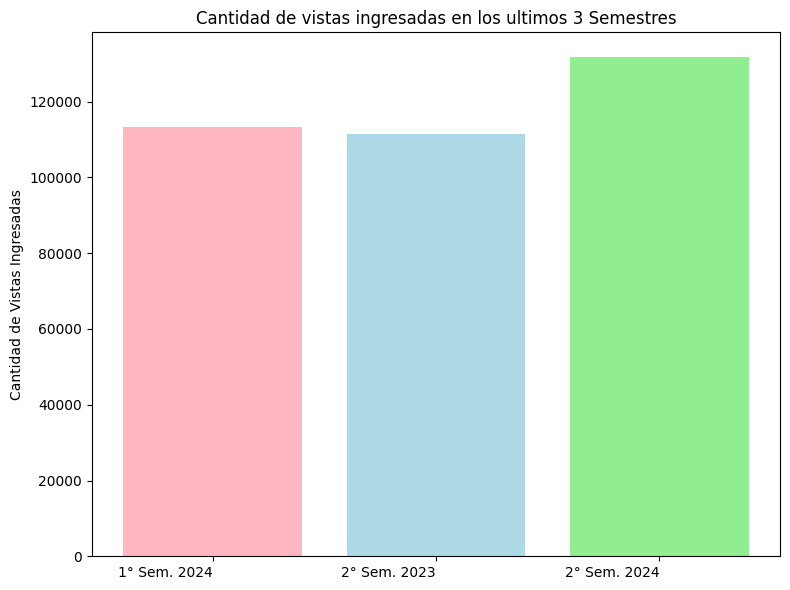

In [5]:

import matplotlib.pyplot as plt

# Datos de ejemplo (reemplaza con tus datos reales)
semestres = vistas_semestres.index
vistas = vistas_semestres.values

# Colores pastel
colores = ['#FFB6C1', '#ADD8E6', '#90EE90']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura si es necesario
plt.bar(semestres, vistas, color=colores)

# Personalizar el gráfico
plt.ylabel('Cantidad de Vistas Ingresadas')
plt.title('Cantidad de vistas ingresadas en los ultimos 3 Semestres')
plt.xticks(rotation=0, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad

# Mostrar el gráfico
plt.tight_layout() # Ajusta el gráfico para que no se corte
plt.show()

**VISTAS INGRASADAS POR JURISDICCION** Pagina 26

In [6]:
all_semestres_data = df.groupby(['Jurisdicción', 'Semestre'])['Vistas Ingresadas'].sum().reset_index()
#print(all_semestres_data)

pivot_table = all_semestres_data.pivot(index='Jurisdicción', columns='Semestre', values='Vistas Ingresadas').fillna(0)

tabla(pivot_table,'2_vistas_por_jurisficcion_distrito.xlsx')


,Total,2° Sem. 2023 (%),1° Sem. 2024 (%)
CABA,94911,15.0,17.0
Córdoba,5504,47.0,31.0
San Martín,4409,27.0,28.0
La Plata,4030,26.0,9.0
Rosario,4001,9.0,2.0
Mendoza,3566,36.0,-0.0
Tucumán,2287,142.0,61.0
Salta,2010,14.0,5.0
General Roca,1997,-6.0,-4.0
Bahía Blanca,1908,13.0,11.0


**VISTAS INGRASADAS POR PROVINCIA** Pagina *28*

In [7]:


all_semestres_data = df.groupby(['Provincia', 'Semestre'])['Vistas Ingresadas'].sum().reset_index()
#print(all_semestres_data)

pivot_table = all_semestres_data.pivot(index='Provincia', columns='Semestre', values='Vistas Ingresadas').fillna(0)

tabla(pivot_table,'3_vistas_por_Provincia.xlsx')



,Total,2° Sem. 2023 (%),1° Sem. 2024 (%)
CABA,94911,15.0,17.0
Buenos Aires,12049,22.0,12.0
Cordoba,5394,46.0,32.0
Santa Fe,3865,6.0,2.0
Mendoza,3209,155.0,71.0
Salta,1612,16.0,2.0
Entre Rios,1599,30.0,3.0
Tucuman,1395,172.0,56.0
Río Negro,1068,-28.0,-2.0
Neuquén,1002,53.0,2.0


**Vistas Ingreadas CABA por Fuero y Materia** Pagina 29

In [8]:


all_semestres_data = df[df['Jurisdicción'] == 'CABA'].groupby(['Fuero', 'Semestre'])['Vistas Ingresadas'].sum().reset_index()

pivot_table = all_semestres_data.pivot(index='Fuero', columns='Semestre', values='Vistas Ingresadas').fillna(0)

name = '4_vistas_por_Fuero.xlsx'
tabla(pivot_table,name)


,Total,2° Sem. 2023 (%),1° Sem. 2024 (%)
Nac. Civ. y Com.,43119,10.0,15.0
"Fed. Civ., Com. y Cont. Admin.",27865,35.0,24.0
Fed. de la Seg. Social,12576,7.0,12.0
Nac. de Trabajo,9955,2.0,16.0
Electoral,1396,31.0,29.0
Total General,94911,15.0,17.0


# Vistas Ingresadas por dependencia Agrupadas por Jurisdiccion
Interior - Pagina 31

In [9]:
jurisdicciones_interior = df[df['Jurisdicción'] != 'CABA']
Jurisdicciones = jurisdicciones_interior['Jurisdicción'].unique()
#ordenar
Jurisdicciones.sort()


for jurisdiccion in Jurisdicciones:
    all_semestres_data = df[df['Jurisdicción'] == jurisdiccion].groupby(['Semestre','Dependencia'])['Vistas Ingresadas'].sum().reset_index()
    pivot_table = all_semestres_data.pivot(index='Dependencia', columns='Semestre', values='Vistas Ingresadas').fillna(0)
    name = f'7_{jurisdiccion}_vistas_ingresadas.xlsx'
    print()
    print(jurisdiccion)
    J=tabla(pivot_table,name)
    print(J)
    print("-"*100)

jurisdicciones_interior = df[df['Jurisdicción'] == 'CABA']
fueros = jurisdicciones_interior['Fuero'].unique()
fueros.sort()

for fuero in fueros:
    all_semestres_data = df[df['Fuero'] == fuero].groupby(['Semestre','Dependencia'])['Vistas Ingresadas'].sum().reset_index()
    pivot_table = all_semestres_data.pivot(index='Dependencia', columns='Semestre', values='Vistas Ingresadas').fillna(0)
    name = f'7_{fuero}_vistas_ingresadas.xlsx'
    print()
    print ("CABA | " + fuero)
    resultado = tabla(pivot_table,name)
    print(resultado)
    print("-"*100)


Bahía Blanca
                                                    Total  2° Sem. 2023 (%)  \
Fisc. Fed. Nº 1 de Bahía Blanca                       573               7.0   
Fisc. Gral. ante la Cám. Fed. de Apel. de Bahía...    542              27.0   
Fisc. Fed. Nº 2 de Bahía Blanca                       487              -4.0   
Fisc. Fed. de Santa Rosa                              306              44.0   
Total General                                        1908              13.0   

                                                    1° Sem. 2024 (%)  
Fisc. Fed. Nº 1 de Bahía Blanca                                 20.0  
Fisc. Gral. ante la Cám. Fed. de Apel. de Bahía...              13.0  
Fisc. Fed. Nº 2 de Bahía Blanca                                 -9.0  
Fisc. Fed. de Santa Rosa                                        34.0  
Total General                                                   11.0  
-------------------------------------------------------------------------------------

**Vistas Ingresadas por Instancia a nivel pais** -Pagina 41




In [10]:
all_semestres_data = df.groupby(['Instancia', 'Semestre'])['Vistas Ingresadas'].sum().reset_index()
#print(all_semestres_data)

pivot_table = all_semestres_data.pivot(index='Instancia', columns='Semestre', values='Vistas Ingresadas').fillna(0)

tabla(pivot_table,'8_vistas_Instancia.xlsx')

,Total,2° Sem. 2023 (%),1° Sem. 2024 (%)
1° Inst.,118109,17.0,16.0
2° Inst.,13622,30.0,18.0
Total General,131731,18.0,16.0


**Vistas Ingresadas por Instancia en CABA - Pagina 42**

In [11]:
amba = df[df['Jurisdicción'] == 'CABA']

all_semestres_data = amba.groupby(['Instancia', 'Semestre'])['Vistas Ingresadas'].sum().reset_index()
#print(all_semestres_data)

pivot_table = all_semestres_data.pivot(index='Instancia', columns='Semestre', values='Vistas Ingresadas').fillna(0)

tabla(pivot_table,'9_vistas_Instancia_CABA.xlsx')

,Total,2° Sem. 2023 (%),1° Sem. 2024 (%)
1° Inst.,84551,12.0,17.0
2° Inst.,10360,40.0,22.0
Total General,94911,15.0,17.0


# **Vistas Ingresadas por Instancia en en las Fiscalias Federales no penales con asiento en las provincias - Pagina 43






In [12]:
interior = df[df['Jurisdicción'] != 'CABA']

all_semestres_data = interior.groupby(['Instancia', 'Semestre'])['Vistas Ingresadas'].sum().reset_index()
#print(all_semestres_data)

pivot_table = all_semestres_data.pivot(index='Instancia', columns='Semestre', values='Vistas Ingresadas').fillna(0)

tabla(pivot_table,'10_vistas_Instancia_interior.xlsx')

,Total,2° Sem. 2023 (%),1° Sem. 2024 (%)
1° Inst.,33558,29.0,14.0
2° Inst.,3262,7.0,9.0
Total General,36820,27.0,13.0


**Vistas Ingresadas por materia a nivel pais - Pagina 44**

In [13]:

all_semestres_data = df.groupby(['Materia', 'Semestre'])['Vistas Ingresadas'].sum().reset_index()
#print(all_semestres_data)

pivot_table = all_semestres_data.pivot(index='Materia', columns='Semestre', values='Vistas Ingresadas').fillna(0)

tabla(pivot_table,'11_vistas_ingresadas_por_Materia_pais.xlsx')

,Total,2° Sem. 2023 (%),1° Sem. 2024 (%)
Civ.,37137.0,8.0,15.0
ECiv. Fed.,31258.0,15.0,11.0
Civ. y Com. Fed.,17290.0,49.0,18.0
Seg. Social,12683.0,7.0,13.0
Cont. Admin. Fed.,10779.0,19.0,33.0
Trabajo,10046.0,3.0,17.0
Electoral Civ.,6733.0,134.0,24.0
Com.,5696.0,20.0,15.0
Penal,61.0,-18.0,85.0
Electoral,16.0,1500.0,1500.0


# 20 motivos principales de vista informado - Pagina 45

In [14]:

#vistas ingresadas por motivo de vista informados


df = load_file('2_Motivo_de_vista.xlsx')
#df['Jurisdicción'] = df['Jurisdicción'].replace('Capital Federal', 'CABA')


Index(['Orden', 'Semestre', 'Provincia', 'Jurisdicción', 'Fuero', 'Instancia',
       'Código', 'Dependencia', 'Materia', 'Motivo Vista',
       'Vistas Ingresadas'],
      dtype='object')


In [15]:

all_semestres_data = df.groupby(['Motivo Vista', 'Semestre'])['Vistas Ingresadas'].sum().reset_index()

pivot_table = all_semestres_data.pivot(index='Motivo Vista', columns='Semestre', values='Vistas Ingresadas').fillna(0)


tabla(pivot_table,'12_20_Motivos_de_vista_informados.xlsx',20)



,Total,2° Sem. 2023 (%),1° Sem. 2024 (%)
Competencia,48479.0,34.0,15.0
Habilitación de instancia,14508.0,67.0,18.0
Declaratoria de herederos,11780.0,-10.0,27.0
Carta de Ciudadanía,7590.0,38.0,31.0
Amparo | fondo,7249.0,36.0,39.0
Constitucionalidad,5501.0,32.0,33.0
Vista a fines de que el fiscal se notifique en su despacho,5431.0,inf,37.0
Amparo | Competencia,4348.0,54.0,-3.0
Defensa del consumidor,3114.0,63.0,30.0
Competencia en razón de la materia,3082.0,4.0,-8.0


** *texto en cursiva*20 motivos principales de vista informado - CABA Pagina 47**





In [16]:
amba = df[df['Jurisdicción'] == 'CABA']

all_semestres_data = amba.groupby(['Motivo Vista', 'Semestre'])['Vistas Ingresadas'].sum().reset_index()
#print(all_semestres_data)

pivot_table = all_semestres_data.pivot(index='Motivo Vista', columns='Semestre', values='Vistas Ingresadas').fillna(0)


tabla(pivot_table,'13_20_Motivos_de_vista_caba.xlsx',20)

,Total,2° Sem. 2023 (%),1° Sem. 2024 (%)
Competencia,33536.0,38.0,13.0
Habilitación de instancia,12217.0,71.0,23.0
Declaratoria de herederos,11779.0,-10.0,27.0
Amparo | fondo,5339.0,40.0,47.0
Vista a fines de que el fiscal se notifique en su despacho,5039.0,inf,42.0
Carta de Ciudadanía,4928.0,39.0,31.0
Constitucionalidad,4611.0,49.0,32.0
Defensa del consumidor,3072.0,63.0,30.0
Beneficio de litigar sin gastos | Fondo,2735.0,20.0,-15.0
Competencia en razón de la materia,2602.0,1.0,7.0


**20 motivos principales de vista informado - FISCALIAS FEDERALES CON ASIENTO EN LAS PROVINCIAS - Pagina 48**



In [17]:
interior = df[df['Jurisdicción'] != 'CABA']

all_semestres_data = interior.groupby(['Motivo Vista', 'Semestre'])['Vistas Ingresadas'].sum().reset_index()
#print(all_semestres_data)

pivot_table = all_semestres_data.pivot(index='Motivo Vista', columns='Semestre', values='Vistas Ingresadas').fillna(0)


tabla(pivot_table,'14_20_Motivos_de_vista_provincias.xlsx',20)

,Total,2° Sem. 2023 (%),1° Sem. 2024 (%)
Competencia,14943.0,26.0,19.0
Amparo | Competencia,3199.0,63.0,10.0
Carta de Ciudadanía,2662.0,37.0,31.0
Habilitación de instancia,2291.0,47.0,-1.0
Exclusión del padrón electoral | art. 3 CNE ley 19445,2053.0,504.0,95.0
Amparo | fondo,1910.0,27.0,22.0
Rehabilitación del padrón electoral | art. 5 CNE ley 19445,1344.0,152.0,-26.0
Reajustes por movilidad | Fondo,1310.0,-25.0,-15.0
Ciudadanía | Procedencia (Ley 346),1224.0,inf,inf
Recurso de Apelación,1210.0,-11.0,6.0


In [18]:
files_to_file("Vistas_ingresadas_V")

Archivos combinados en Vistas_ingresadas_V.xlsx
Archivo 7_Comodoro Rivadavia_vistas_ingresadas.xlsx eliminado correctamente.
Archivo 2_vistas_por_jurisficcion_distrito.xlsx eliminado correctamente.
Archivo 7_Salta_vistas_ingresadas.xlsx eliminado correctamente.
Archivo 7_Nac. de Trabajo_vistas_ingresadas.xlsx eliminado correctamente.
Archivo 7_Mendoza_vistas_ingresadas.xlsx eliminado correctamente.
Archivo 7_Rosario_vistas_ingresadas.xlsx eliminado correctamente.
Archivo 7_Corrientes_vistas_ingresadas.xlsx eliminado correctamente.
Archivo 7_Electoral_vistas_ingresadas.xlsx eliminado correctamente.
Archivo 10_vistas_Instancia_interior.xlsx eliminado correctamente.
Archivo 11_vistas_ingresadas_por_Materia_pais.xlsx eliminado correctamente.
Archivo 7_Mar del Plata_vistas_ingresadas.xlsx eliminado correctamente.
Archivo 12_20_Motivos_de_vista_informados.xlsx eliminado correctamente.
Archivo 13_20_Motivos_de_vista_caba.xlsx eliminado correctamente.
Archivo 7_La Plata_vistas_ingresadas.xlsx 

# Dictamenes emitidos en el segundo semestre de 2024 - Pagina 50




In [ ]:

#vistas ingresadas por motivo de vista informados

df=load_file('3_Dictámenes.xlsx')

Index(['Orden', 'Semestre', 'Provincia', 'Jurisdicción', 'Fuero', 'Instancia',
       'Código', 'Dependencia', 'Dictámenes Emitidos', 'Género'],
      dtype='object')


In [ ]:
Dictámenes_semestres = df.groupby('Semestre')['Dictámenes Emitidos'].sum().astype(int)

Dictámenes_semestres_semestres_pivot = Dictámenes_semestres.to_frame().T  # Transpone el DataFrame

nuevo_orden = ['2° Sem. 2023', '1° Sem. 2024', '2° Sem. 2024']  # Reemplaza con los nombres reales de tus columnas
Dictámenes_semestres_semestres_pivot = Dictámenes_semestres_semestres_pivot[nuevo_orden]

# Estilo para añadir un título que ocupe todas las columnas
Dictámenes_semestres_styled = Dictámenes_semestres_semestres_pivot.style\
    .set_caption("Cantidad de vistas ingresadas en los ultimos 3 Semestres")\
    .set_table_styles([
        {'selector': 'th.col_heading', 'props': 'text-align: center; font-weight: bold; border: 1px solid black;'},
        {'selector': 'thead th', 'props': 'text-align: center; font-weight: bold; border: 1px solid black;'},
        {'selector': 'table', 'props': 'width: 100%; border-collapse: collapse;'},
        {'selector': 'caption', 'props': 'text-align: center; font-size: 1.2em; font-weight: bold;'},
        {'selector': 'td', 'props': 'border: 1px solid black;'}
    ])\
    .set_properties(**{'text-align': 'center'})\

Dictámenes_semestres_styled.to_excel('1_dictamenes_emitidos_3_semestres.xlsx', index=False)
Dictámenes_semestres_styled

# **Cantidad de dictamenes por Jurisdicion o Distrito - Pagina 51**


In [ ]:

all_semestres_data = df.groupby(['Jurisdicción', 'Semestre'])['Dictámenes Emitidos'].sum().reset_index()
#print(all_semestres_data)

pivot_table = all_semestres_data.pivot(index='Jurisdicción', columns='Semestre', values='Dictámenes Emitidos').fillna(0)

tabla(pivot_table,'2_Dictamenes_por_jurisficcion_distrito.xlsx')




In [ ]:
#Cantidad de dictamenes emitidos en CABA por fuero y materia - Pagina 53


all_semestres_data = df[df['Jurisdicción'] == 'CABA'].groupby(['Fuero', 'Semestre'])['Dictámenes Emitidos'].sum().reset_index()

pivot_table = all_semestres_data.pivot(index='Fuero', columns='Semestre', values='Dictámenes Emitidos').fillna(0)

name = '3_dictamenes_emitidos_por_Fuero.xlsx'
tabla(pivot_table,name)

In [ ]:

#Dictamenes emitidos por dependencia (Interior) - Agrupados por Jurisdiccion - Pagina 54

jurisdicciones_interior = df[df['Jurisdicción'] != 'CABA']
Jurisdicciones = jurisdicciones_interior['Jurisdicción'].unique()
Jurisdicciones.sort()

for jurisdiccion in Jurisdicciones:
    all_semestres_data = df[df['Jurisdicción'] == jurisdiccion].groupby(['Semestre','Dependencia'])['Dictámenes Emitidos'].sum().reset_index()
    pivot_table = all_semestres_data.pivot(index='Dependencia', columns='Semestre', values='Dictámenes Emitidos').fillna(0)
    name = f'4_{jurisdiccion}_Dictamenes_Emitidos.xlsx'
    print()
    print(jurisdiccion)
    T=tabla(pivot_table,name)
    print(T)
    print("-"*100)



#Dictamenes emitidos por Dependencia - Agrupados por Fuero - Pagina 54


jurisdicciones_interior = df[df['Jurisdicción'] == 'CABA']
fueros = jurisdicciones_interior['Fuero'].unique()
fueros.sort()

for fuero in fueros:
    all_semestres_data = df[df['Fuero'] == fuero].groupby(['Semestre','Dependencia'])['Dictámenes Emitidos'].sum().reset_index()
    pivot_table = all_semestres_data.pivot(index='Dependencia', columns='Semestre', values='Dictámenes Emitidos').fillna(0)
    name = f'4_{fuero}_Dictamenes_Emitidos.xlsx'
    print()
    print("CABA | " + fuero )
    T=tabla(pivot_table,name)
    print(T)
    print("-"*100)


In [ ]:
#vistas ingresadas por motivo de vista informados


df=load_file('4_Dictámenes_por_temática.xlsx')

# **20 Principales Tematicas Generales en Dictamenes - Total Pais**

In [ ]:
all_semestres_data = df.groupby(['Temática', 'Semestre'])['Dictámenes Emitidos'].sum().reset_index()

pivot_table = all_semestres_data.pivot(index='Temática', columns='Semestre', values='Dictámenes Emitidos').fillna(0)

tabla(pivot_table,'5_20_Principales_tematicas_pais'+ jurisdiccion +'.xlsx',20)



# 10 Principales Tematicas Generales en Dictamenes por Jurisdiccion o Distrito - Pagina 65 - Interior

In [ ]:

jurisdicciones = df['Jurisdicción'].unique()
jurisdicciones.sort()

for jurisdiccion in jurisdicciones:
    all_semestres_data = df[df['Jurisdicción'] == jurisdiccion].groupby(['Temática', 'Semestre'])['Dictámenes Emitidos'].sum().reset_index()

    pivot_table = all_semestres_data.pivot(index='Temática', columns='Semestre', values='Dictámenes Emitidos').fillna(0)
    print(jurisdiccion)
    T=tabla(pivot_table,'6_10_Principales_tematicas_'+ jurisdiccion +'.xlsx',10)
    print(T)

    print("-"*100)


amba = df[df['Jurisdicción'] == 'CABA']
Fueros = amba['Fuero'].unique()


for Fuero in Fueros:
    all_semestres_data = amba[amba['Fuero'] == Fuero].groupby(['Temática', 'Semestre'])['Dictámenes Emitidos'].sum().reset_index()

    pivot_table = all_semestres_data.pivot(index='Temática', columns='Semestre', values='Dictámenes Emitidos').fillna(0)
    print(Fuero)
    T=tabla(pivot_table,'6_10_Principales_tematicas_'+ Fuero +'.xlsx',10)
    print(T)

    print("-"*100)


In [ ]:
#Dictamenes con cuestion de Genero - Pagina 76


df=load_file('3_Dictámenes.xlsx')

genero = df[df['Género']>0]

all_semestres_data = genero.groupby(['Semestre','Jurisdicción','Dependencia'])['Género'].sum().reset_index()

pivot_table = all_semestres_data.pivot(index='Dependencia', columns='Semestre', values='Género').fillna(0)
pivot_table

T=tabla(pivot_table,'7_Dictamenes_Genero.xlsx')

genero = T[T['Total']>0]
print(genero)


In [ ]:
files_to_file("Dictamenes_Emitidos_VI")

# Tasa de resolucion por jurisdiccion / Distrito- Pagina 77

In [ ]:


df=load_file('5_Tasa.xlsx')


In [ ]:

all_semestres_data = df.groupby(['Jurisdicción', 'Semestre']).agg({
    'Vistas Ingresadas': 'sum',
    'Vistas Evacuadas': 'sum'
}).reset_index()

all_semestres_data['Tasa'] = (all_semestres_data['Vistas Evacuadas'] / all_semestres_data['Vistas Ingresadas']).round(2)


pivot_table = all_semestres_data.pivot(index='Jurisdicción', columns='Semestre', values='Tasa').fillna(0)
tabla(pivot_table,'1_Tasa.xlsx',1001,2)

# TASA por *Fuero* - Pagina 78

In [ ]:
all_semestres_data = df.groupby(['Fuero', 'Semestre']).agg({
    'Vistas Ingresadas': 'sum',
    'Vistas Evacuadas': 'sum'
}).reset_index()

all_semestres_data['Tasa'] = (all_semestres_data['Vistas Evacuadas'] / all_semestres_data['Vistas Ingresadas']).round(2)


pivot_table = all_semestres_data.pivot(index='Fuero', columns='Semestre', values='Tasa').fillna(0)
tabla(pivot_table,'2_Tasa_Fuero.xlsx',None,2)

# Tasa por Jurisdicion o Distrito

In [ ]:

jurisdicciones = df['Jurisdicción'].unique()
jurisdicciones.sort()

all_semestres_data = df.groupby(['Dependencia', 'Jurisdicción','Semestre']).agg({
        'Vistas Ingresadas': 'sum',
        'Vistas Evacuadas': 'sum'
    }).reset_index()

all_semestres_data['Tasa'] = (all_semestres_data['Vistas Evacuadas'] / all_semestres_data['Vistas Ingresadas']).round(2)

for jurisdiccion in jurisdicciones:
    data_jurisdiccion = all_semestres_data[all_semestres_data['Jurisdicción'] == jurisdiccion]
    pivot_table = data_jurisdiccion.pivot(index='Dependencia', columns='Semestre', values='Tasa').fillna(0)
    print(jurisdiccion)
    T=tabla(pivot_table,'3_Tasa_'+ jurisdiccion +'.xlsx',None,2)
    print(T)

    print("-"*100)

In [ ]:
files_to_file("TASA_de_Resolucion_VII")

# STOCK DE EXPEDIENTES

In [ ]:
df = load_file('6_Sock.xlsx')

df['Fecha Tope'] = pd.to_datetime(df['Fecha Tope']).dt.strftime('%Y-%m-%d %H:%M:%S')

fechas = df['Fecha Tope'].unique()
mapeo_fecha_semestre = {
    '2023-12-31 00:00:00': '2° Sem. 2023',
    '2024-06-30 00:00:00': '1° Sem. 2024',
    '2024-12-31 00:00:00': '2° Sem. 2024'

}

mapeo_fecha_orden = {
    '2023-12-31 00:00:00': 1,
    '2024-06-30 00:00:00': 2,
    '2024-12-31 00:00:00': 3
}

# Reemplazar los valores en la columna "Fecha Tope" con "Semestre"
df['Semestre'] = df['Fecha Tope'].map(mapeo_fecha_semestre)

# Crear la nueva columna "Orden"
df['Orden'] = df['Fecha Tope'].map(mapeo_fecha_orden)

# Eliminar la columna "Fecha Tope" si ya no es necesaria
df.drop(columns=['Fecha Tope'], inplace=True)

all_semestres_data = df.groupby(['Jurisdicción', 'Semestre'])['Stock Expedientes'].sum().reset_index()

pivot_table = all_semestres_data.pivot(index='Jurisdicción', columns='Semestre', values='Stock Expedientes').fillna(0)
tabla(pivot_table,'1_STOCK_Jurisdicción.xlsx')



STOCK POR FUERO - CABA



In [ ]:
all_semestres_data = df.groupby(['Fuero', 'Semestre']).sum()['Stock Expedientes'].reset_index()

pivot_table = all_semestres_data.pivot(index='Fuero', columns='Semestre', values='Stock Expedientes').fillna(0)
tabla(pivot_table,'3_STOCK_Fuero.xlsx')




# **STOCK POR DEPENDENCIA AGRUPADOS POR JURISDICCION Y FUERO**

In [ ]:

#Dictamenes emitidos por dependencia (Interior) - Agrupados por Jurisdiccion - Pagina 54

jurisdicciones_interior = df[df['Jurisdicción'] != 'CABA']
Jurisdicciones = jurisdicciones_interior['Jurisdicción'].unique()
Jurisdicciones.sort()

for jurisdiccion in Jurisdicciones:
    all_semestres_data = df[df['Jurisdicción'] == jurisdiccion].groupby(['Semestre','Dependencia'])['Stock Expedientes'].sum().reset_index()
    pivot_table = all_semestres_data.pivot(index='Dependencia', columns='Semestre', values='Stock Expedientes').fillna(0)
    name = f'4_{jurisdiccion}_Stock_Expedientes.xlsx'
    print()
    print(jurisdiccion)
    T=tabla(pivot_table,name)
    print(T)
    print("-"*100)



#Dictamenes emitidos por Dependencia - Agrupados por Fuero - Pagina 54


jurisdicciones_interior = df[df['Jurisdicción'] == 'CABA']
fueros = jurisdicciones_interior['Fuero'].unique()
fueros.sort()

for fuero in fueros:
    all_semestres_data = df[df['Fuero'] == fuero].groupby(['Semestre','Dependencia'])['Stock Expedientes'].sum().reset_index()
    pivot_table = all_semestres_data.pivot(index='Dependencia', columns='Semestre', values='Stock Expedientes').fillna(0)
    name = f'4_{fuero}_Stock_Expedientes.xlsx'
    print()
    print("CABA | " + fuero )
    T=tabla(pivot_table,name)
    print(T)
    print("-"*100)


In [ ]:
files_to_file("Stock_de_exp_VIII")

# **Tiempos de Gestion**

In [ ]:

df = load_file('7_Tiempos.xlsx')


In [ ]:
# prompt: con df necesito agrupar los datos en 10 rangos (de 0 a 1, de 1,2, hasta 9 a 10, por ultimo los mayores a 10) de dias e ir contado la cantidad de registros que corresponde a cada grupo y una columna que represente el porcentaje del total

import pandas as pd

bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, float('inf')]
labels = [f'{i}-{i+1}' for i in range(10)] + ['>10']
# Categorize 'Dias' into the bins
df['Rango_Dias'] = pd.cut(df['Total días'], bins=bins, labels=labels, right=False)

# Group by the 'Rango_Dias' and count the occurrences
grouped_data = df.groupby('Rango_Dias').size().reset_index(name='Cantidad_Registros')

# Calculate the percentage of the total
grouped_data['Porcentaje'] = ((grouped_data['Cantidad_Registros'] / grouped_data['Cantidad_Registros'].sum()) * 100).round(2)


total_registros = grouped_data['Cantidad_Registros'].sum()

# Create a new row with the total values
total_row = pd.DataFrame({'Rango_Dias': ['Total'],
                            'Cantidad_Registros': [total_registros],
                            'Porcentaje': [grouped_data['Porcentaje'].sum().round(2)]})

grouped_data = pd.concat([grouped_data, total_row], ignore_index=True)
# Print or use the grouped_data dataframe


grouped_data.to_excel('1_tiempos_rango_en_dias.xlsx', index=False)

grouped_data


# **Tiempo de gestion por Jurisdiccion en dias**

In [ ]:
# Calcular el promedio de 'Total Dias' por 'Jurisdicción'
average_days_per_jurisdiction = df.groupby('Jurisdicción')['Total días'].mean().round(2)
average_days_per_jurisdiction = average_days_per_jurisdiction.sort_values()

grouped_data.to_excel('2_tiempos_rango_en_dias.xlsx', index=False)

print(average_days_per_jurisdiction)




# Tiempo promedio de gestion por fuero y materia

In [ ]:
average_days_per_Fuero = df.groupby('Fuero')['Total días'].mean().round(2)
average_days_per_Fuero = average_days_per_Fuero.sort_values()

grouped_data.to_excel('3_tiempos_fuero_materia_en_dias.xlsx', index=False)

print(average_days_per_Fuero)


In [ ]:


jurisdicciones_interior = df[df['Jurisdicción'] != 'CABA']
Jurisdicciones = jurisdicciones_interior['Jurisdicción'].unique()
Jurisdicciones.sort()

for jurisdiccion in Jurisdicciones:

    average_days_per_jurisdiction = df[df['Jurisdicción'] == jurisdiccion].groupby(['Dependencia'])['Total días'].mean().round(2)
    average_days_per_jurisdiction = average_days_per_jurisdiction.sort_values()
    print(average_days_per_jurisdiction)
    print(average_days_per_Fuero)
    name = f'4_{jurisdiccion}_tiempos.xlsx'
    average_days_per_jurisdiction.to_excel(name, index=False)

    print()
    print(jurisdiccion)
    print("-"*100)

print()




jurisdicciones_interior = df[df['Jurisdicción'] == 'CABA']
fueros = jurisdicciones_interior['Fuero'].unique()
fueros.sort()

for fuero in fueros:
    average_days_per_Fuero = df[df['Fuero'] == fuero].groupby(['Dependencia'])['Total días'].mean().round(2)

    average_days_per_Fuero = average_days_per_Fuero.sort_values()
    print(average_days_per_Fuero)

    name = f'4_{fuero}_tiempos.xlsx'
    average_days_per_Fuero.to_excel(name, index=False)

    print()
    print("CABA | " + fuero )
    print("-"*100)


# tiempo promedio de gestion por tematica general en dias


In [ ]:
average_days_per_tematica = df.groupby('Temática gral.')['Total días'].mean().round(2)
average_days_per_tematica = average_days_per_tematica.sort_values(ascending=False).head(20)

#average_days_per_tematica.to_excel("5_tiempo_por_tematica", index=False)
#falta terminar
print(average_days_per_tematica)



# **tiempo por instancia**

In [ ]:
import pandas as pd
import numpy as np

grouped = df.groupby('Instancia').agg(
    record_count = pd.NamedAgg(column="Total días", aggfunc="size"),
    Promedio_en_Dias = pd.NamedAgg(column="Total días", aggfunc="mean"),
).round(2).reset_index()

total_records = grouped['record_count'].sum()
grouped['weight'] = grouped['record_count'] / total_records

weighted_average = np.average(grouped['Promedio_en_Dias'], weights=grouped['weight'])


print("Promedio de dias por Instancia:")
T=grouped[['Instancia','Promedio_en_Dias']]
print(T)
print(f"\nPromedio ponderado: {weighted_average.round(2)}")
#T.to_excel("6_tiempo_por_instancia", index=False)

#FALTA BAJAR A EXCEL


In [ ]:
files_to_file("Tiempos_IX")

# **Notificaciones (3 ULTIMOS SEMESTRES)** PAGINA 116

In [ ]:

df = load_file('8_Notificaciones.xlsx')

In [ ]:
# Agrupa por Semestre y suma las vistas ingresadas
Notificaciones_semestre = df.groupby('Orden')['Total Notificaciones'].sum().astype(int)

Notificaciones_semestre_pivot = Notificaciones_semestre.to_frame() # Convierte a DataFrame
Notificaciones_semestre_pivot.columns = [''] # Cambia el nombre de columna a vacío# Convierte el resultado a un DataFrame con los semestres como columnas
Notificaciones_semestre_pivot = Notificaciones_semestre.to_frame().T  # Transpone el DataFrame
# Elimina el índice para que no aparezca como la primera columna

Notificaciones_semestre_pivot.index = ['']
# Estilo para añadir un título que ocupe todas las columnas
vistas_semestres_styled = Notificaciones_semestre_pivot.style.set_caption("**Vistas Notificaciones por Semestre**")\
    .set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center; font-weight: bold; border: 1px solid black;'},
        {'selector': 'thead th', 'props': 'text-align: center; font-weight: bold; border: 1px solid black;'},
        {'selector': 'table', 'props': 'width: 100%; border-collapse: collapse;'},  # Use collapse instead of solid
        {'selector': 'caption', 'props': 'text-align: center; font-size: 1.2em; font-weight: bold;'},
        {'selector': 'td', 'props': 'border: 1px solid black;'} # Add border to table cells

    ])\
    .set_properties(**{'text-align': 'center'})


vistas_semestres_styled.to_excel('1_Notificaciones_ingresadas_3_semestres.xlsx', index=False)
vistas_semestres_styled


In [ ]:
all_semestres_data = df.groupby(['Jurisdicción', 'Semestre'])['Total Notificaciones'].sum().reset_index()
pivot_table = all_semestres_data.pivot(index='Jurisdicción', columns='Semestre', values='Total Notificaciones').fillna(0)
name = '8_Notificaciones_por_Jurisdicción.xlsx'
final=tabla(pivot_table,name)


Notificaciones = df[df['Semestre'] == '1° Sem. 2024'].groupby('Jurisdicción')[['Total Notificaciones','Notificaciones Electrónicas', 'Notificaciones Físicas']].sum()
Notificaciones = Notificaciones.sort_values(by='Total Notificaciones', ascending=False)
Notificaciones = Notificaciones.drop(columns=['Total Notificaciones'])
final = final.join(Notificaciones)
nuevo_orden = ['Notificaciones Electrónicas', 'Notificaciones Físicas', 'Total', '1° Sem. 2024 (%)','2° Sem. 2023 (%)']

# Reordenar las columnas
final = final[nuevo_orden]

final = final.fillna(0).astype({
    'Total': 'int',
    'Notificaciones Electrónicas': 'int',
    'Notificaciones Físicas': 'int',
    '1° Sem. 2024 (%)':'int',
    '2° Sem. 2023 (%)':'int'

})
#final.to_excel("2_notificaciones_por_jurisdiccion", index=False)

print(final)



# **Cantidad de Notificaciones Por Fuero y materia** Pagina

In [ ]:
all_semestres_data = df[df['Jurisdicción'] == 'CABA'].groupby(['Fuero', 'Semestre'])['Total Notificaciones'].sum().reset_index()

pivot_table = all_semestres_data.pivot(index='Fuero', columns='Semestre', values='Total Notificaciones').fillna(0)

name = '8_Notificaciones_por_Fuero.xlsx'
final=tabla(pivot_table,name)


Notificaciones = df[df['Semestre'] == '1° Sem. 2024'].groupby('Fuero')[['Total Notificaciones','Notificaciones Electrónicas', 'Notificaciones Físicas']].sum()
Notificaciones = Notificaciones.sort_values(by='Total Notificaciones', ascending=False)
Notificaciones = Notificaciones.drop(columns=['Total Notificaciones'])
final = final.join(Notificaciones)
nuevo_orden = ['Notificaciones Electrónicas', 'Notificaciones Físicas', 'Total', '1° Sem. 2024 (%)','2° Sem. 2023 (%)']

# Reordenar las columnas
final = final[nuevo_orden]

final = final.fillna(0).astype({
    'Total': 'int',
    'Notificaciones Electrónicas': 'int',
    'Notificaciones Físicas': 'int',
    '1° Sem. 2024 (%)':'int',
    '2° Sem. 2023 (%)':'int'

})

print(final)

# **Notificaciones por Instancia**

In [ ]:
all_semestres_data = df.groupby(['Instancia', 'Semestre'])['Total Notificaciones'].sum().reset_index()

pivot_table = all_semestres_data.pivot(index='Instancia', columns='Semestre', values='Total Notificaciones').fillna(0)

name = '8_Notificaciones_por_instancia.xlsx'
final=tabla(pivot_table,name)
print(final)


# **Los Motivos de notificacion mas frecuentes**



In [ ]:

df = load_file('9_Motivo_Notificacion.xlsx')

In [ ]:
df_semestre =df[df['Semestre'] == '2° Sem. 2024']
df_no_informado = df_semestre[df['Motivo'] == 'No informado']
df_sin_no_informado = df_semestre[df['Motivo'] != 'No informado']


df1 = df_no_informado.groupby(['Motivo'])['Total Notificaciones'].sum().reset_index()
df2 = df_sin_no_informado.groupby(['Motivo'])['Total Notificaciones'].sum().sort_values(ascending=False).reset_index()


# print(df2.head(20))
# print(df1)
df_final = pd.concat([df2.head(20),df1], axis=0)
print(df_final)

# name = '8_Notificaciones_por_motivo.xlsx'
# final=tabla(pivot_table,name,None,20)
# print(final)

# **Notificaciones electronicas enviadas incorrectamente**

In [ ]:
# Agrupa por Semestre y suma las vistas ingresadas

vistas_semestres = df[df['Envíos Incorrectos'] > 0].groupby('Orden')['Envíos Incorrectos'].sum()
vistas_semestres_pivot = vistas_semestres.to_frame() # Convierte a DataFrame
vistas_semestres_pivot.columns = [''] # Cambia el nombre de columna a vacío# Convierte el resultado a un DataFrame con los semestres como columnas
vistas_semestres_pivot = vistas_semestres.to_frame().T  # Transpone el DataFrame
# Elimina el índice para que no aparezca como la primera columna

vistas_semestres_pivot.index = ['']
# Estilo para añadir un título que ocupe todas las columnas
vistas_semestres_styled = vistas_semestres_pivot.style.set_caption("**Notificaciones Enviadas Incorrectamente**")\
    .set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center; font-weight: bold; border: 1px solid black;'},
        {'selector': 'thead th', 'props': 'text-align: center; font-weight: bold; border: 1px solid black;'},
        {'selector': 'table', 'props': 'width: 100%; border-collapse: collapse;'},  # Use collapse instead of solid
        {'selector': 'caption', 'props': 'text-align: center; font-size: 1.2em; font-weight: bold;'},
        {'selector': 'td', 'props': 'border: 1px solid black;'} # Add border to table cells

    ])\
    .set_properties(**{'text-align': 'center'})


vistas_semestres_styled.to_excel('1_vistas_ingresadas_3_semestres.xlsx', index=False)
vistas_semestres_styled


In [ ]:
df=df.sort_values(by='Orden', ascending=True) # es importante

all_semestres_data =  df[df['Envíos Incorrectos'] > 0].groupby(['Jurisdicción', 'Semestre'])['Envíos Incorrectos'].sum().reset_index()
#print(all_semestres_data)
pivot_table = all_semestres_data.pivot(index='Jurisdicción', columns='Semestre', values='Envíos Incorrectos').fillna(0)

tabla(pivot_table,'2_notificaciones_Envíos Incorrectos.xlsx')

In [ ]:
df=df.sort_values(by='Orden', ascending=True) # es importante
df=df[df['Jurisdicción'] == 'CABA']

all_semestres_data =  df[df['Envíos Incorrectos'] > 0].groupby(['Fuero', 'Semestre'])['Envíos Incorrectos'].sum().reset_index()
#print(all_semestres_data)
pivot_table = all_semestres_data.pivot(index='Fuero', columns='Semestre', values='Envíos Incorrectos').fillna(0)

tabla(pivot_table,'2_notificaciones_Envíos Incorrectos.xlsx')

In [ ]:
files_to_file("Notificaciones_X")